<a href="https://colab.research.google.com/github/davidgoldbach/BestSellerRanking/blob/main/shalion_v03_REG_DAG_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Llibreries

In [1]:
# Imports and more
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df=pd.read_csv('dades.csv',sep=",")
print("Data shape",df.shape)
print("Categories Number: ",len(df['SEED_DESCRIPTION'].unique().tolist()))
print("Product Number: ",len(df['DISCOVERY_KEY'].unique().tolist()))

Data shape (142569, 11)
Categories Number:  1581
Product Number:  119643


In [2]:
df.columns

Index(['SEED_CATEGORY_NAME', 'SEED_DESCRIPTION', 'SEED_ID', 'TIMEFRAME_NAME',
       'DATE', 'RANK', 'DISCOVERY_KEY', 'SEED_VALUE', 'STORE_ID',
       'FETCH_DATETIME', 'NUMBERSELLS'],
      dtype='object')

# Preprocessament dades


In [3]:
df=df.sort_values(by='FETCH_DATETIME',ascending=False)
df=df.drop_duplicates(subset=['SEED_ID','FETCH_DATETIME','DISCOVERY_KEY'],keep='first')
df=df.sort_values(by=['SEED_CATEGORY_NAME', 'SEED_DESCRIPTION', 'SEED_ID'])

In [4]:
df.head(1)

,SEED_CATEGORY_NAME,SEED_DESCRIPTION,SEED_ID,TIMEFRAME_NAME,DATE,RANK,DISCOVERY_KEY,SEED_VALUE,STORE_ID,FETCH_DATETIME,NUMBERSELLS
99,Automotive > Accessories > Exterior,Home > Best Sellers > Automotive > Car Care > ...,9937af5d-0174-3d7c-8a10-51d1694382f1,best_seller,2024-11-09,100.0,B00MLG4CX2,https://www.amazon.com/Best-Sellers-Automotive...,a4701adb-b8dc-34a8-b48f-aa16a25a9c7f,2024-11-09 12:22:09.320,NaN


In [5]:
# Proving Ranks 1 to 100
df.groupby('SEED_VALUE')['SEED_VALUE'].count().sort_values()

,SEED_VALUE
SEED_VALUE,
https://www.amazon.com/Best-Sellers-Automotive-Flywheel-Locks/zgbs/automotive/15707631,1
https://www.amazon.com/Best-Sellers-Grocery-Gourmet-Food-Seasonal-Beers/zgbs/grocery/17691541011,1
https://www.amazon.com/Best-Sellers-Grocery-Gourmet-Food-Lager-Pilsner-Beers/zgbs/grocery/15158295011,1
https://www.amazon.com/Best-Sellers-Grocery-Gourmet-Food-Sangria/zgbs/grocery/18327545011,2
https://www.amazon.com/Best-Sellers-Grocery-Gourmet-Food-Beer-Variety-Packs/zgbs/grocery/17691542011,2
...,...
https://www.amazon.com/Best-Sellers-Electronics-Video-Equipment/zgbs/electronics/7161073011,100
https://www.amazon.com/Best-Sellers-Electronics-Vehicle-GPS-Units-Equipment/zgbs/electronics/559938,100
https://www.amazon.com/Best-Sellers-Electronics-VCRs/zgbs/electronics/172669,100


In [6]:
### Proving seed_values and SEED_DESCRIPTION equivalence
a=df.groupby('SEED_VALUE')['SEED_VALUE'].count().sort_values()
print("Number of seed values", a.shape)

Number of seed values (1582,)


In [7]:
print("Number of distinct seed values",df.SEED_VALUE.unique().shape)
print("Number of distinct seed descripctions / Categories",df.SEED_DESCRIPTION.unique().shape)

Number of distinct seed values (1582,)
Number of distinct seed descripctions / Categories (1581,)


In [8]:
### DUPLICATED CATEGORY https://www.amazon.com/gp/bestsellers/blank/678540011 IS FROM Home > Best Seller > Home & Kitchen > Kitchen & Dining > Small Appliances > Rice Cookers

df=df[df['SEED_VALUE']!="https://www.amazon.com/gp/bestsellers/blank/678540011"]

In [9]:
print("Number of distinct seed values",df.SEED_VALUE.unique().shape)
print("Number of distinct seed descripctions / Categories",df.SEED_DESCRIPTION.unique().shape)

Number of distinct seed values (1581,)
Number of distinct seed descripctions / Categories (1581,)


In [10]:
df.sort_values(by=['SEED_DESCRIPTION','RANK'],inplace=True)
df.reset_index(inplace=True,drop=True)
df2=df.copy()

# GARVELL DE PRODUCTES A CATEGORIES (Eliminem productes que surten a categories superiors) (SUPOSEM ORDRE CORRECTE)

In [11]:
L=[]
LL=[]
for i in range(df.shape[0]):
  if df.iloc[i,6] not in L:
    L.append(df.iloc[i,6])
  else:
    LL.append(i)

In [12]:
df.drop(LL,inplace=True)
df.reset_index(inplace=True,drop=True)

In [13]:
print("Eliminem :",len(LL), "productes /files")
## ara cada producte surt només a la seva primera categoria
## per tant hi ha tantes rows com productes
print("Ara hi ha",len(df['DISCOVERY_KEY'].unique())," productes")
print("Ara hi ha",df.shape[0]," files")
print("Hi ha tants productes com files?: ",len(df['DISCOVERY_KEY'].unique())==df.shape[0])

Eliminem : 22876 productes /files
Ara hi ha 119643  productes
Ara hi ha 119643  files
Hi ha tants productes com files?:  True


In [ ]:
df.to_excel("dades_def_20241114.xlsx")

In [14]:
numero_productes=len(df['DISCOVERY_KEY'].unique())

# Creem la relació al conjunt de productes (antisimètrica, transitiva..). L'ordre parcial

In [15]:
df.sort_values(by=['SEED_DESCRIPTION','RANK'],inplace=True)
df.reset_index(inplace=True,drop=True)

In [16]:
categories=df['SEED_DESCRIPTION'].unique()
list_partial_relation=[]
for i in categories:
  df_aux=df[df['SEED_DESCRIPTION']==i]
  df_aux.sort_values(by='RANK',inplace=True)
  df_aux.reset_index(drop=True,inplace=True)
  for j in range(df_aux.shape[0]-1):
    list_partial_relation.append([df_aux.iloc[j,6],df_aux.iloc[j+1,6]])


In [17]:
def subcat(c1,c2):
  res=False
  if (c1 in c2):
    if (c2.replace(c1,"").count(">")==1):
      res=True
  return res

In [18]:
for i in range(len(categories)-1):
  for j in range(i+1,len(categories)):
    if subcat(categories[i],categories[j]):
      product0=df[df['SEED_DESCRIPTION']==categories[i]].iloc[-1,6]
      product1=df[df['SEED_DESCRIPTION']==categories[j]].iloc[0,6]
      list_partial_relation.append([product0,product1])

In [ ]:
## Exemple d'algunes relacions de productes
list_partial_relation[0:10]

[['B0009YWKUA', 'B009IOCCD2'],
 ['B009IOCCD2', 'B01EY9KQ2Y'],
 ['B01EY9KQ2Y', 'B00BD741WM'],
 ['B00BD741WM', 'B003CL3PTM'],
 ['B003CL3PTM', 'B001VIWHMY'],
 ['B001VIWHMY', 'B09K9FDLFN'],
 ['B09K9FDLFN', 'B003MGAIDI'],
 ['B003MGAIDI', 'B00FBT7XAK'],
 ['B00FBT7XAK', 'B09RPL4Z4J'],
 ['B09RPL4Z4J', 'B07L5FF4W3']]

In [19]:
## Guardem les relacions en un EXCEL
rel=pd.DataFrame(list_partial_relation)
#rel.to_excel("relation.xlsx")

## Fem la Toplogical Sort (ens permetrà demanar possibles ordres totals)

In [20]:
import numpy as np
import networkx as nx


def get_random_topological_sort(graph):
    """Compute a random topological sort for a directed graph."""
    # Wrapper around _get_random_topological_sort that handles graphs with non-integer nodes.
    mapping = dict(zip(sorted(graph), range(len(graph))))
    integer_graph = nx.relabel_nodes(graph, mapping=mapping, copy=True)
    integer_nodes = _get_random_topological_sort(integer_graph)
    inverse_mapping = dict(zip(mapping.values(), mapping.keys()))
    return [inverse_mapping[ii] for ii in integer_nodes]


def _get_random_topological_sort(graph):
    """Compute a random topological sort for a directed graph with integer nodes."""

    order = np.arange(len(graph))
    np.random.shuffle(order)

    # compute a random topological sort for each component
    ptr = 0
    sorted_nodes = np.zeros((len(graph)), dtype=int)
    for component in nx.connected_components(graph.to_undirected()):
        # re-initialize subgraph with random node order
        np.random.shuffle(list(component))
        subgraph = nx.DiGraph()
        subgraph.add_nodes_from(component)
        subgraph.add_edges_from(nx.subgraph(graph, component).edges())

        # combine results across components
        indices = list(sorted(order[ptr:ptr+len(component)]))
        sorted_nodes[indices] = list(nx.topological_sort(subgraph))

        ptr += len(component)

    return sorted_nodes


In [21]:

def find_paths_to_leaves(graph, start, target):
    paths = []

    # Paso 1: Encontrar todos los caminos desde la raíz al nodo objetivo
    def dfs_to_target(current_node, path):
        path.append(current_node)
        if current_node == target:
            dfs_to_leaves(target, path)  # Extender el camino hasta las hojas
        else:
            for neighbor in graph.successors(current_node):
                dfs_to_target(neighbor, path)
        path.pop()

    # Paso 2: Continuar desde el nodo objetivo hasta las hojas
    def dfs_to_leaves(current_node, path):
        if graph.out_degree(current_node) == 0:  # Nodo hoja
            paths.append(list(path))
        else:
            for neighbor in graph.successors(current_node):
                path.append(neighbor)
                dfs_to_leaves(neighbor, path)
                path.pop()

    # Identificar la raíz del DAG
    # root = [n for n in graph.nodes if graph.in_degree(n) == 0][0]

    # Iniciar el recorrido
    dfs_to_target(start, [])
    return paths

def find_root(graph, node):
    current_node = node
    while list(graph.predecessors(current_node)):  # Mientras tenga predecesores
        current_node = list(graph.predecessors(current_node))[0]
    return current_node

def fill_sales_path_dic(path, df):
    keys = path[0]  # Lista de claves
    filtered_df = df[df['DISCOVERY_KEY'].isin(paths[0])]
    values = filtered_df['NUMBERSELLS']  # Lista de valores
    return dict(zip(keys, values))
def fill_sales_path_df(path, df):
    data = pd.DataFrame({'product':path[0]})  # Lista de claves
    data = pd.merge(data, df[['NUMBERSELLS','DISCOVERY_KEY']], left_on='product', right_on='DISCOVERY_KEY', how='left')
    data.drop('DISCOVERY_KEY', axis=1, inplace=True)
    data['RANK']=list(range(1,len(path[0])+1))
    return data
def trim_nans_sales(df):
  start_idx = df['NUMBERSELLS'].first_valid_index()  # Primera fila válida
  end_idx = df['NUMBERSELLS'].last_valid_index()    # Última fila válida
  return df.loc[start_idx:end_idx]

In [22]:
## Creem el Graph afegint els nodes amb els productes i els edges amb les relacions
nodes=df['DISCOVERY_KEY'].unique()
edges = list_partial_relation

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
df['predicted']=False
df.reset_index(drop=True,inplace=True)
for i in range(0,df.shape[0]):
  if i%1000==0:
    print(i)
  if (pd.isnull(df.loc[i,"NUMBERSELLS"])) & (df.loc[i,"predicted"]==False):
    node=df.loc[i,"DISCOVERY_KEY"]
    root=find_root(G, node)
    paths = find_paths_to_leaves(G, root, node)
    aux1=trim_nans_sales(fill_sales_path_df(paths,df))
    reg=aux1.dropna()
    pred=aux1[aux1['NUMBERSELLS'].isnull()]
    df.loc[df['DISCOVERY_KEY'].isin(pred['product']),'predicted']=True

    if (reg.shape[0]>3) & ((pred.shape[0]>0)):
      X=reg.drop(columns=['NUMBERSELLS','product'],inplace=False)
      y=reg['NUMBERSELLS']
      from sklearn.model_selection import train_test_split
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

      # first model
      LReg = LinearRegression()
      LReg.fit(X_train,y_train)
      predictions = LReg.predict(X_test)
      performance=mean_squared_error(y_test, predictions)
      n_based=reg.shape[0]
      new_predictions = LReg.predict(pred[['RANK']])
      pred['rank_pred_reg1']=new_predictions
      pred['performance_Reg1']=performance
      pred['n_Reg1']=n_based
      df.loc[df['DISCOVERY_KEY'].isin(pred['product']), 'rank_pred_reg1'] =pred['rank_pred_reg1'].values
      df.loc[df['DISCOVERY_KEY'].isin(pred['product']), 'performance_Reg1'] =pred['performance_Reg1'].values
      df.loc[df['DISCOVERY_KEY'].isin(pred['product']), 'n_Reg1'] =pred['n_Reg1'].values

      # second model
      DT = DecisionTreeRegressor()
      DT.fit(X_train,y_train)
      predictions = DT.predict(X_test)
      performance=mean_squared_error(y_test, predictions)
      n_based=reg.shape[0]
      new_predictions = DT.predict(pred[['RANK']])
      pred['rank_pred_DT']=new_predictions
      pred['performance_DT']=performance
      pred['n_DT']=n_based
      df.loc[df['DISCOVERY_KEY'].isin(pred['product']), 'rank_pred_DT'] =pred['rank_pred_DT'].values
      df.loc[df['DISCOVERY_KEY'].isin(pred['product']), 'performance_DT'] =pred['performance_DT'].values
      df.loc[df['DISCOVERY_KEY'].isin(pred['product']), 'n_DT'] =pred['n_DT'].values

      # third model
      LReg = LinearRegression()
      ln_y_train = np.log(y_train)
      LReg.fit(X_train,ln_y_train)
      predictions = np.exp(LReg.predict(X_test))
      performance=mean_squared_error(y_test, predictions)
      n_based=reg.shape[0]
      new_predictions = LReg.predict(pred[['RANK']])
      pred['rank_pred_reg_log']=np.exp(new_predictions)
      pred['performance_reg_log']=performance
      pred['n_reg_log']=n_based
      df.loc[df['DISCOVERY_KEY'].isin(pred['product']), 'rank_pred_reg_log'] =pred['rank_pred_reg_log'].values
      df.loc[df['DISCOVERY_KEY'].isin(pred['product']), 'performance_reg_log'] =pred['performance_reg_log'].values
      df.loc[df['DISCOVERY_KEY'].isin(pred['product']), 'n_reg_log'] =pred['n_reg_log'].values

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000


,SEED_CATEGORY_NAME,SEED_DESCRIPTION,SEED_ID,TIMEFRAME_NAME,DATE,RANK,DISCOVERY_KEY,SEED_VALUE,STORE_ID,FETCH_DATETIME,...,predicted,rank_pred_reg1,performance_Reg1,n_Reg1,rank_pred_DT,performance_DT,n_DT,rank_pred_reg_log,performance_reg_log,n_reg_log
0,Pets > Dog > Food,Home > Best Seller > Animal Products > Dogs > ...,d68279db-53c9-3111-b597-9fca2a411d98,best_seller,2024-11-09,1.0,B0009YWKUA,https://www.amazon.com/gp/bestsellers/blank/29...,a4701adb-b8dc-34a8-b48f-aa16a25a9c7f,2024-11-09 12:37:35.674,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Pets > Dog > Food,Home > Best Seller > Animal Products > Dogs > ...,d68279db-53c9-3111-b597-9fca2a411d98,best_seller,2024-11-09,2.0,B009IOCCD2,https://www.amazon.com/gp/bestsellers/blank/29...,a4701adb-b8dc-34a8-b48f-aa16a25a9c7f,2024-11-09 12:37:35.677,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Pets > Dog > Food,Home > Best Seller > Animal Products > Dogs > ...,d68279db-53c9-3111-b597-9fca2a411d98,best_seller,2024-11-09,3.0,B01EY9KQ2Y,https://www.amazon.com/gp/bestsellers/blank/29...,a4701adb-b8dc-34a8-b48f-aa16a25a9c7f,2024-11-09 12:37:35.679,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Pets > Dog > Food,Home > Best Seller > Animal Products > Dogs > ...,d68279db-53c9-3111-b597-9fca2a411d98,best_seller,2024-11-09,4.0,B00BD741WM,https://www.amazon.com/gp/bestsellers/blank/29...,a4701adb-b8dc-34a8-b48f-aa16a25a9c7f,2024-11-09 12:37:35.681,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pets > Dog > Food,Home > Best Seller > Animal Products > Dogs > ...,d68279db-53c9-3111-b597-9fca2a411d98,best_seller,2024-11-09,5.0,B003CL3PTM,https://www.amazon.com/gp/bestsellers/blank/29...,a4701adb-b8dc-34a8-b48f-aa16a25a9c7f,2024-11-09 12:37:35.684,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119638,DIY > Construction > Insulation and Accessories,Home > BestSellers > Tools & Home Improvement ...,d403ac33-644d-3701-b054-4794a37230fb,best_seller,2024-11-09,96.0,B07K3YL8K9,https://www.amazon.com/Best-Sellers-Tools-Home...,a4701adb-b8dc-34a8-b48f-aa16a25a9c7f,2024-11-09 12:37:35.664,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119639,DIY > Construction > Insulation and Accessories,Home > BestSellers > Tools & Home Improvement ...,d403ac33-644d-3701-b054-4794a37230fb,best_seller,2024-11-09,97.0,B07GVLJ7D5,https://www.amazon.com/Best-Sellers-Tools-Home...,a4701adb-b8dc-34a8-b48f-aa16a25a9c7f,2024-11-09 12:37:35.665,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119640,DIY > Construction > Insulation and Accessories,Home > BestSellers > Tools & Home Improvement ...,d403ac33-644d-3701-b054-4794a37230fb,best_seller,2024-11-09,98.0,B0832QXJVJ,https://www.amazon.com/Best-Sellers-Tools-Home...,a4701adb-b8dc-34a8-b48f-aa16a25a9c7f,2024-11-09 12:37:35.666,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119641,DIY > Construction > Insulation and Accessories,Home > BestSellers > Tools & Home Improvement ...,d403ac33-644d-3701-b054-4794a37230fb,best_seller,2024-11-09,99.0,B07R5HHV8S,https://www.amazon.com/Best-Sellers-Tools-Home...,a4701adb-b8dc-34a8-b48f-aa16a25a9c7f,2024-11-09 12:37:35.668,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df.to_excel("results_sales_prediction.xlsx")

,product,NUMBERSELLS,RANK
0,B07T16DQ31,20000.0,1
1,B0B1S7BTJF,10000.0,2
2,B0BJ6YM9JX,5000.0,3
3,B00HZO6ZVC,9000.0,4
4,B075G6XMSF,10000.0,5
...,...,...,...
95,B0C7GG4K7W,NaN,96
96,B08PDNK6TP,NaN,97
97,B000FNXW5M,NaN,98
98,B0DFHBSF1F,100.0,99


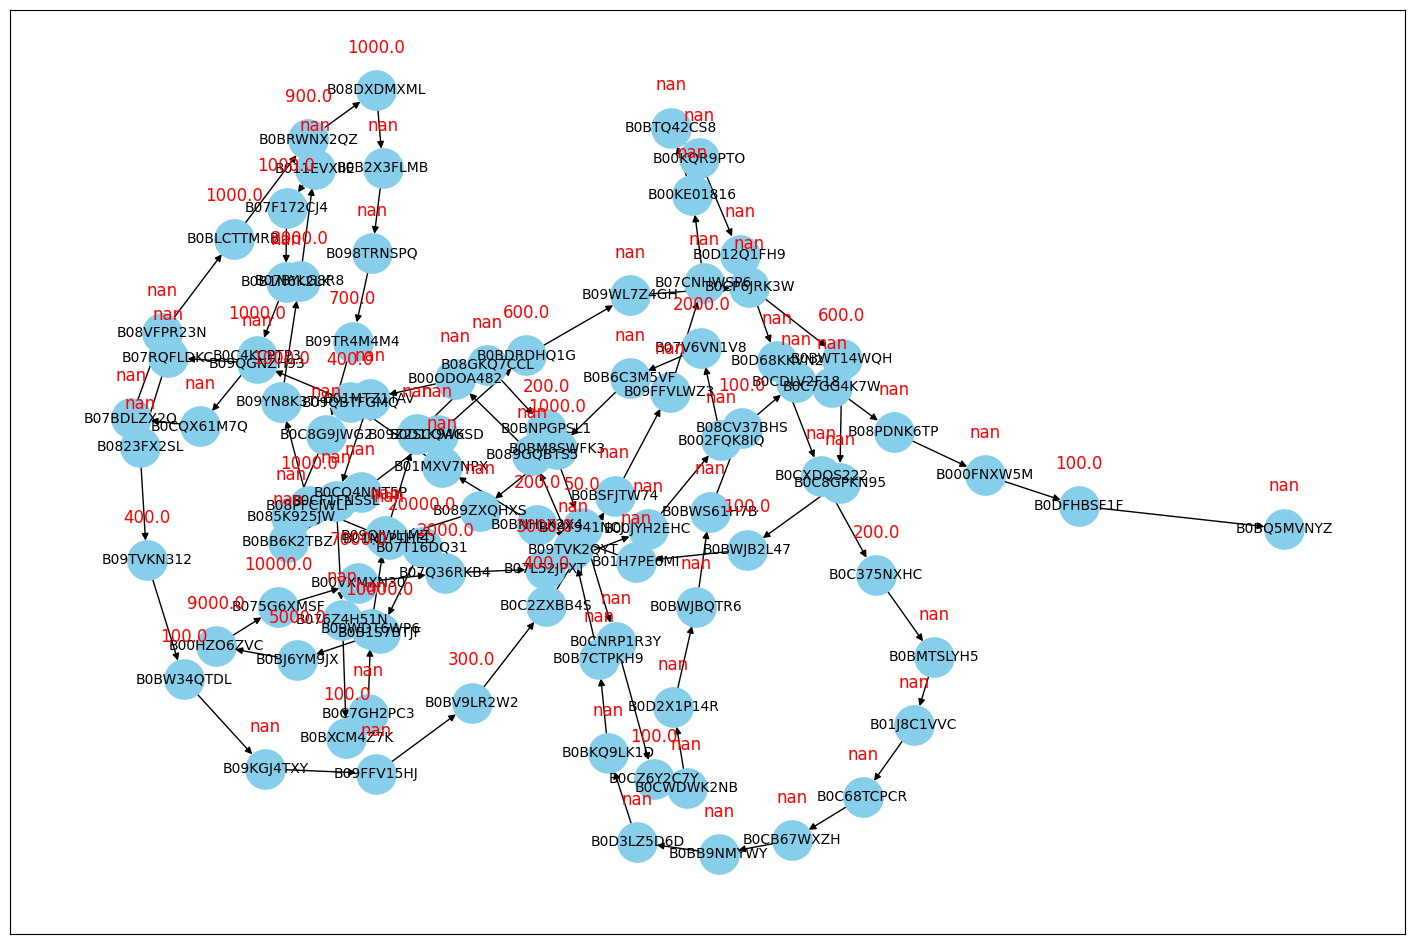

In [43]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,12))
node='B09KGJ4TXY'
root=find_root(G, node)
paths = find_paths_to_leaves(G, root, node)
paths
Gsub=G.subgraph(paths[0])

#nx.draw_networkx(G, arrows=True)
pos = nx.spring_layout(Gsub)
#node_labels = nx.get_node_attributes(G, 'value')
node_labels=fill_sales_path_dic(paths,df)
label_positions = {node: (x, y + 0.05) for node, (x, y) in pos.items()}  # Desplaza las etiquetas hacia arriba

nx.draw_networkx(Gsub, pos, with_labels=True, arrows=True, node_color='skyblue', node_size=800, font_size=10)
nx.draw_networkx_labels(Gsub, label_positions, labels=node_labels, font_color='red', font_size=12)

df_to_graph=fill_sales_path_df(paths,df)
df_to_graph

<Axes: xlabel='RANK', ylabel='NUMBERSELLS'>

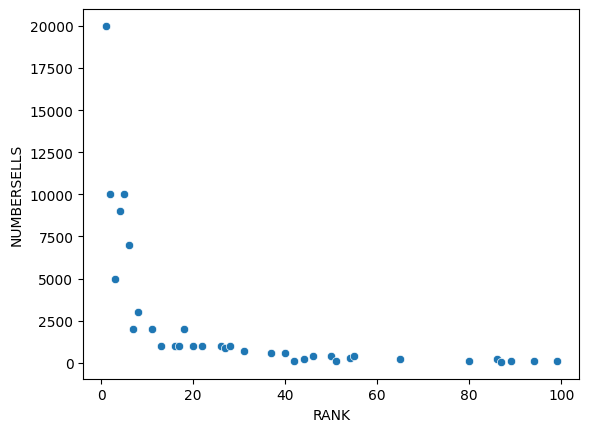

In [44]:
import seaborn as sns
sns.scatterplot(x='RANK',y='NUMBERSELLS',data=df_to_graph)